# SVM - Workout Type Prediction

In [69]:
from google.colab import files
files.upload()

Saving gym_members_exercise_tracking.csv to gym_members_exercise_tracking (7).csv


{'gym_members_exercise_tracking (7).csv': b'Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Workout_Type,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI\n56,Male,88.3,1.71,180,157,60,1.69,1313.0,Yoga,12.6,3.5,4,3,30.2\n46,Female,74.9,1.53,179,151,66,1.3,883.0,HIIT,33.9,2.1,4,2,32.0\n32,Female,68.1,1.66,167,122,54,1.11,677.0,Cardio,33.4,2.3,4,2,24.71\n25,Male,53.2,1.7,190,164,56,0.59,532.0,Strength,28.8,2.1,3,1,18.41\n38,Male,46.1,1.79,188,158,68,0.64,556.0,Strength,29.2,2.8,3,1,14.39\n56,Female,58.0,1.68,168,156,74,1.59,1116.0,HIIT,15.5,2.7,5,3,20.55\n36,Male,70.3,1.72,174,169,73,1.49,1385.0,Cardio,21.3,2.3,3,2,23.76\n40,Female,69.7,1.51,189,141,64,1.27,895.0,Cardio,30.6,1.9,3,2,30.57\n28,Male,121.7,1.94,185,127,52,1.03,719.0,Strength,28.9,2.6,4,2,32.34\n28,Male,101.8,1.84,169,136,64,1.08,808.0,Cardio,29.7,2.7,3,1,30.07\n41,Male,120.8,1.67,188,146,54,0.82,593.0,HIIT,20.5,3.0,2,1,43.31\n53,Mal

In [70]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance
warnings.filterwarnings('ignore')
print('Kütüphaneler yüklendi.')

Kütüphaneler yüklendi.


In [71]:
# [1] Data Load
try:
    df = pd.read_csv('gym_members_exercise_tracking.csv')
    print(f"Veri yüklendi. Row: {df.shape[0]}, Column: {df.shape[1]}")
except FileNotFoundError:
    print("Hata: 'gym_members_exercise_tracking.csv' dosyası bulunamadı.")

Veri yüklendi. Row: 973, Column: 15



============================== EDA ==============================
EDA görselleri kaydedildi.


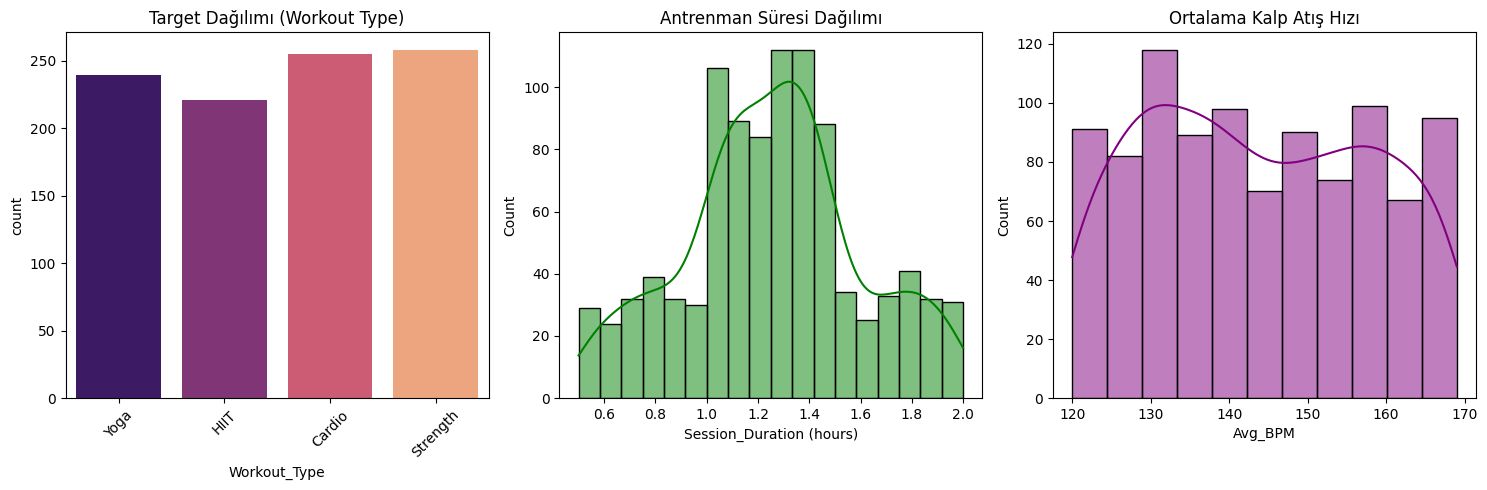

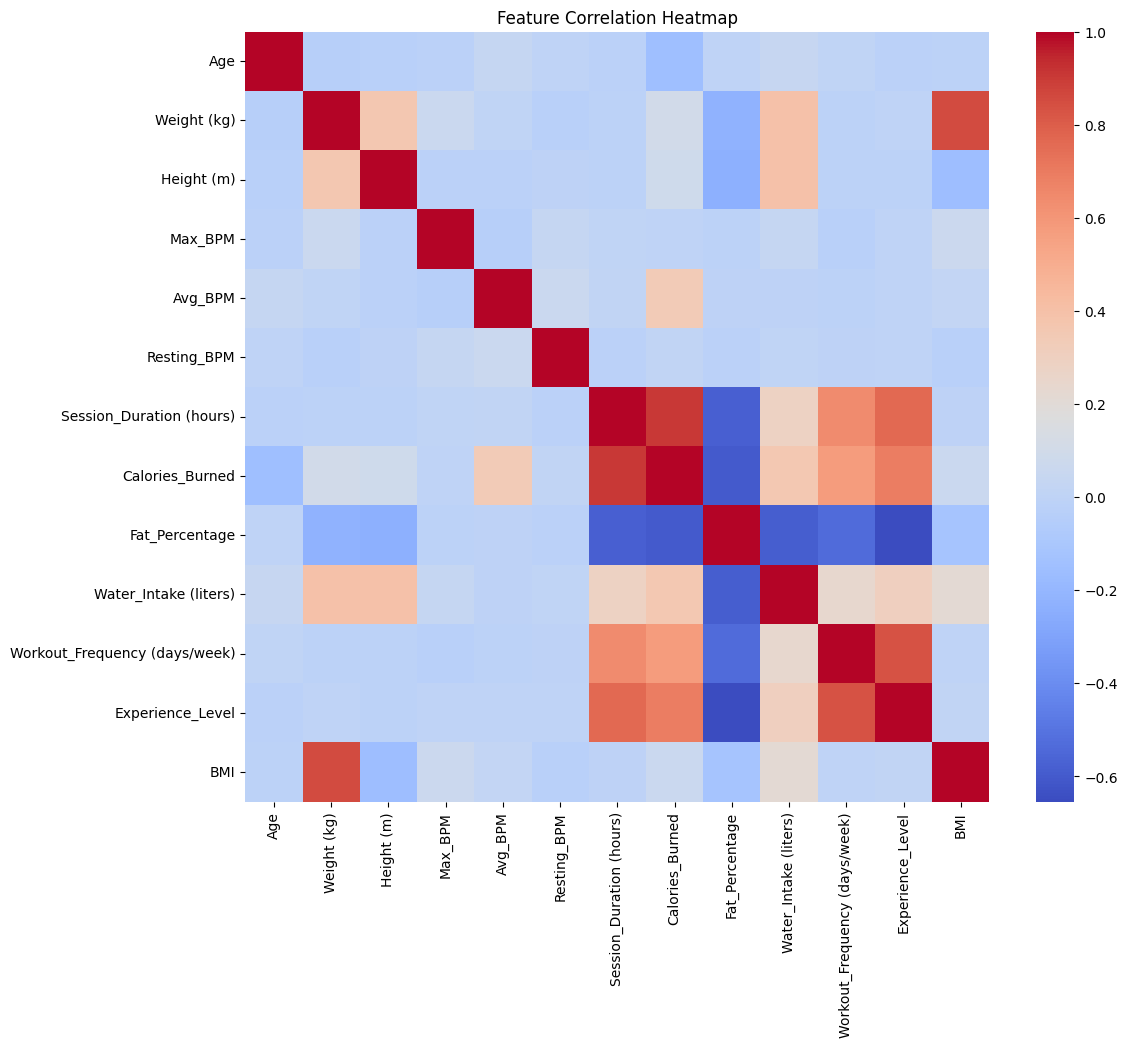

In [72]:
# [2] EDA (Exploratory Data Analysis)
print("\n" + "="*30 + " EDA " + "="*30)
plt.figure(figsize=(15, 5))

# Target Dağılımı
plt.subplot(1, 3, 1)
sns.countplot(x='Workout_Type', data=df, palette='magma')
plt.title('Target Dağılımı (Workout Type)')
plt.xticks(rotation=45)

# Histogram: Session Duration
plt.subplot(1, 3, 2)
sns.histplot(df['Session_Duration (hours)'], kde=True, color='green')
plt.title('Antrenman Süresi Dağılımı')

# Histogram: Avg_BPM)
plt.subplot(1, 3, 3)
sns.histplot(df['Avg_BPM'], kde=True, color='purple')
plt.title('Ortalama Kalp Atış Hızı')
plt.tight_layout()
plt.savefig('eda_plots_workout.png')

# Correlation Heatmap (Sayısal değişkenler arası ilişki)
plt.figure(figsize=(12, 10))
numeric_df = df.select_dtypes(include=[np.number])
sns.heatmap(numeric_df.corr(), annot=False, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.savefig('correlation_heatmap_workout.png')
print("EDA görselleri kaydedildi.")

In [73]:
# [3] Feature Engineering
df['HR_per_minute'] = df['Avg_BPM'] / (df['Session_Duration (hours)'] * 60)
df['Intensity_per_Weight'] = df['Calories_Burned'] / df['Weight (kg)']
df['HRR'] = df['Max_BPM'] - df['Resting_BPM']
df['Efficiency'] = df['Calories_Burned'] / df['Avg_BPM']
df['Experience_Adjusted_Calories'] = df['Calories_Burned'] / (df['Experience_Level'] + 1)
df['Anaerobic_Index'] = (df['Max_BPM'] - df['Avg_BPM']) / df['Resting_BPM']
df['BPM_Variance_Rest'] = (df['Avg_BPM'] - df['Resting_BPM']) ** 2
df['Heart_Instability'] = abs(df['Max_BPM'] - df['Avg_BPM']) / df['Max_BPM']

#Encoding
le_gender = LabelEncoder()
le_workout = LabelEncoder()
df['Gender_Encoded'] = le_gender.fit_transform(df['Gender'])
df['Workout_Encoded'] = le_workout.fit_transform(df['Workout_Type'])

target_names = le_workout.classes_ # ['Cardio', 'HIIT', 'Strength', 'Yoga'] gibi

# Feature Selection
feature_cols = [
    'Age', 'Gender_Encoded', 'Weight (kg)', 'Height (m)', 'Max_BPM', 'Avg_BPM', 'Resting_BPM',
    'Session_Duration (hours)', 'Calories_Burned', 'Workout_Frequency (days/week)',
    'Fat_Percentage', 'Water_Intake (liters)', 'Experience_Level', 'BMI',
    'HR_per_minute', 'Intensity_per_Weight', 'HRR', 'Efficiency',
    'Experience_Adjusted_Calories', 'Anaerobic_Index', 'BPM_Variance_Rest', 'Heart_Instability'
]
X = df[feature_cols]
y = df['Workout_Encoded']
print(f'Features: {X.shape[1]}')

Features: 22


In [74]:
# [4] Train / Test Split & Scaling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
print(f'Train: {X_train.shape[0]}, Test: {X_test.shape[0]}')

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(f"Feature sayısı: {len(feature_cols)}. Veri ölçeklendirildi.")

Train: 681, Test: 292
Feature sayısı: 22. Veri ölçeklendirildi.


In [75]:
# [5] Model Training (Baseline, Tuned, CV)
print("\n" + "="*30 + " MODEL TRAINING " + "="*30)
# Baseline
print('\n' + '='*70)
print('BASELINE MODEL')
print('='*70)
svm_baseline = SVC(kernel='rbf', random_state=42)
svm_baseline.fit(X_train_scaled, y_train)
print(f'Train: {accuracy_score(y_train, svm_baseline.predict(X_train_scaled)):.4f}')
print(f'Test:  {accuracy_score(y_test, svm_baseline.predict(X_test_scaled)):.4f}')

# Tuned (GridSearchCV)
param_grid = {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto', 0.1], 'kernel': ['rbf', 'poly']}
grid_search = GridSearchCV(SVC(random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)
best_model = grid_search.best_estimator_

# CV Score
cv_scores = cross_val_score(best_model, X_train_scaled, y_train, cv=5)

print(f"\nEn İyi Parametreler: {grid_search.best_params_}")
print(f"Cross-Validation Accuracy: {cv_scores.mean():.4f}")


============================== MODEL TRAINING ==============================

BASELINE MODEL
Train: 0.4949
Test:  0.2329

En İyi Parametreler: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Cross-Validation Accuracy: 0.2982



============================== EVALUATION ==============================


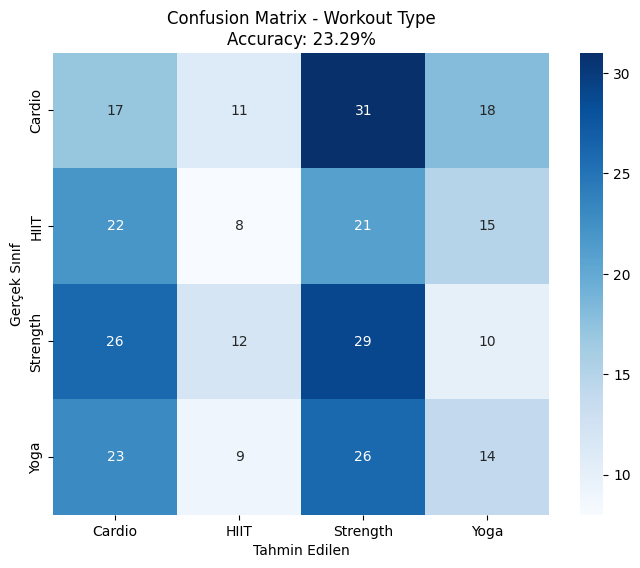

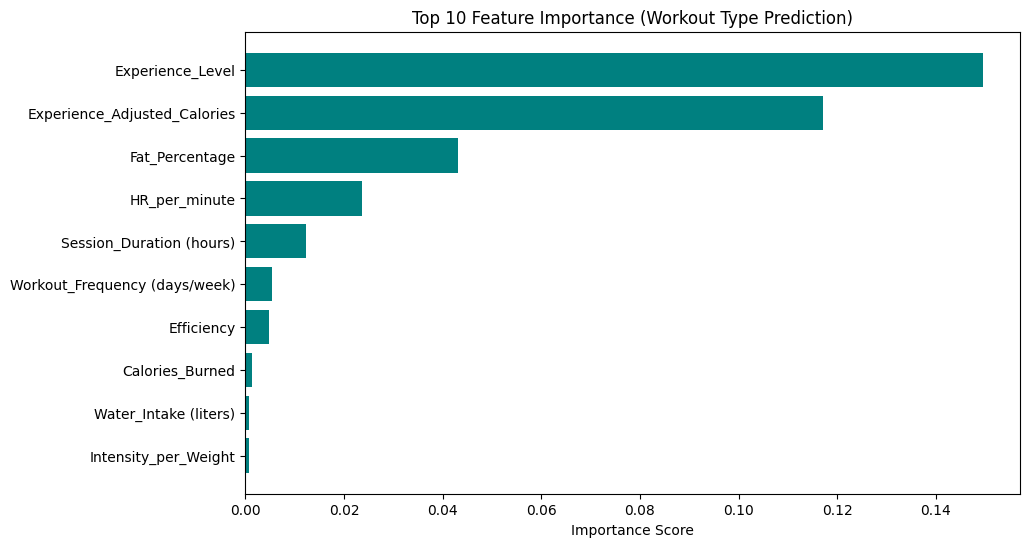

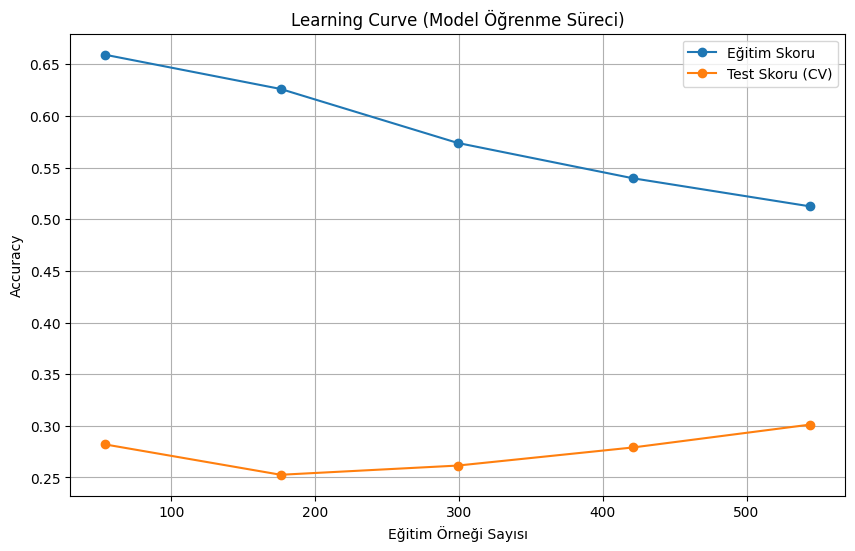

In [76]:
# [6] Evaluation
print("\n" + "="*30 + " EVALUATION " + "="*30)
y_pred = best_model.predict(X_test_scaled)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title(f'Confusion Matrix - Workout Type\nAccuracy: {accuracy_score(y_test, y_pred):.2%}')
plt.ylabel('Gerçek Sınıf')
plt.xlabel('Tahmin Edilen')
plt.savefig('confusion_matrix_workout.png')

# Feature Importance (Permutation Importance)

# RBF kernel'da katsayılar (coefficients) doğrudan alınamadığı için,
# modelin değişkenlere verdiği önemi anlamak amacıyla Permutation Importance yöntemi kullanılmıştır.
erm_importance = permutation_importance(best_model, X_test_scaled, y_test, n_repeats=10, random_state=42)
sorted_idx = perm_importance.importances_mean.argsort()[-10:]

plt.figure(figsize=(10, 6))
plt.barh(np.array(feature_cols)[sorted_idx], perm_importance.importances_mean[sorted_idx], color='teal')
plt.title("Top 10 Feature Importance (Workout Type Prediction)")
plt.xlabel("Importance Score")
plt.savefig('feature_importance_workout.png')

# Learning Curve
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train_scaled, y_train, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5))

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label="Eğitim Skoru")
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label="Test Skoru (CV)")
plt.title("Learning Curve (Model Öğrenme Süreci)")
plt.xlabel("Eğitim Örneği Sayısı")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.savefig('learning_curve_workout.png')

In [77]:
# [7] Final Conclusions
print("\n" + "="*30 + " FINAL CONCLUSIONS " + "="*30)
print(f"1. Test Seti Başarısı: {accuracy_score(y_test, y_pred):.4f}")
print(f"2. En Belirleyici Özellikler: {np.array(feature_cols)[sorted_idx[-1]]} ve {np.array(feature_cols)[sorted_idx[-2]]}")
print(f"3. Model Kararlılığı (CV): {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")
print("\nDetaylı Sınıflandırma Raporu:")
print(classification_report(y_test, y_pred, target_names=target_names))


============================== FINAL CONCLUSIONS ==============================
1. Test Seti Başarısı: 0.2329
2. En Belirleyici Özellikler: Experience_Level ve Experience_Adjusted_Calories
3. Model Kararlılığı (CV): 0.2982 (+/- 0.0603)

Detaylı Sınıflandırma Raporu:
              precision    recall  f1-score   support

      Cardio       0.19      0.22      0.21        77
        HIIT       0.20      0.12      0.15        66
    Strength       0.27      0.38      0.32        77
        Yoga       0.25      0.19      0.22        72

    accuracy                           0.23       292
   macro avg       0.23      0.23      0.22       292
weighted avg       0.23      0.23      0.23       292

